## CAB420 Assignment 2 (For Viewing Only)

In [1]:
import os
from glob import glob
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt     # for plotting
import cv2 
import soundfile as sf

import librosa
import pandas as pd
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras import activations
from tensorflow.keras.regularizers import l2

from time import process_time

from collections import Counter

from PIL import Image

2023-06-03 20:11:12.390675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 20:11:13.523944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kevin/venv/cab420/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-03 20:11:13.523970: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-03 20:11:15.817818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; d

**Global Variables**

Select: sample rate, length of audio, sample size

In [50]:
# Data path:
data_path = '../data/'
speakers_path = '../data/SPEAKERS.TXT'

sample_rate = 10000
off_set = 0
duration = 5.0 #All samples are 5 seconds

# If you decide to use batch sizes:
batch_size = 1000

sample_size = (round((sample_rate*duration)), 1)

**Helper Functions**

In [10]:
def extract_id_sex():
    id_sex_array = []
    with open(speakers_path, 'r') as file:
        # Skip the header line
        next(file)
        for line in file:
            # Split the line into columns
            columns = line.split('|')
            # Extract the ID and SEX
            id_value = columns[0].strip()
            sex_value = columns[1].strip()
            # Append ID and SEX to the array
            id_sex_array.append((id_value, sex_value))
    return id_sex_array

# Lets store the speaker gender, it'll only be used once.
speaker_gender = extract_id_sex()

def load_directory():
    # Find all samples in the directory
    files = glob(os.path.join(data_path, '*.flac'))
    # The audio data
    x = []
    # The gender and speaker ID
    y = []

    # Create a dictionary for speaker genders
    speaker_gender_dict = {speaker[0]: speaker[1] for speaker in speaker_gender}

    counter_f = 0
    counter_m = 0
    speakers = []

    if batch_size > len(files):
        error_msg = f'Requested a batch size greater than the number of samples available ({len(files)})'
        raise ValueError(error_msg)

    for file in files:
        if (len(x) == batch_size):
            break
        
        # Collect the speaker IDs, because we are classifying on gender the speakerID does not 
        # matter as a label, but it does help us ensure we have a diverse representation of 
        # speakers for each gender, so we will only take 1 sample per speaker for each gender.
        
        fileName = file.split('/')[2]
        speakerId = fileName.split('-')[0]

        # Due to limited number of samples per speaker limit the below code to 14500
        if batch_size < 14500:
            # extract an even number of samples from each speaker ensuring we get a diverse
            # range of speakers 
            num_samples_per_speaker = round(batch_size / 250)
            speaker_count = Counter(speakers)
            if (speaker_count[speakerId] >= num_samples_per_speaker):
                continue
        
        # Use dictionary for faster search performance.
        gender = speaker_gender_dict.get(speakerId)

        if (gender == 'F' and (counter_f < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((0, speakerId))
            speakers.append(speakerId)
            counter_f = counter_f + 1

        elif (gender == 'M' and (counter_m < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((1, speakerId))
            speakers.append(speakerId)
            counter_m = counter_m + 1

    return np.array(x), np.array(y, dtype=int)

def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

def plot_images(x,y):
    fig = plt.figure(figsize=[10, 7])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('gray'))
        ax.set_title(y[i])
        ax.axis('off')


## Pre-processing

x_data = audio data

y = Either 1 (male) or 0 (female)

Evenly distribute the data across gender and Split the data into training and testing sets

Convert audio samples x_data into mel-spectrograms

In [51]:
x_data, y = load_directory()
# Information on the extracted audio data:
print(f'x data, first sample: {x_data[0]}')
print(f'shape x data: {x_data.shape}')

y_data = np.array([row[0] for row in y])
print("first 10 y data: " + str(y_data[:10]))
speakerIds = [row[1] for row in y]
print(f'shape y data: {y_data.shape}')

f_rows = y[y[:, 0] == 0]
m_rows = y[y[:, 0] == 1]
print()
print(f'Female Speakers - {len(np.unique(f_rows[:, 1]))} : {np.unique(f_rows)}')
print(f'Male Speakers - {len(np.unique(m_rows[:, 1]))}: {np.unique(m_rows)}')

x data, first sample: [ 0.00273745  0.00373503 -0.00156174 ...  0.07941885  0.09780262
  0.11707062]
shape x data: (1000, 50000)
first 10 y data: [1 0 1 0 0 0 1 0 1 0]
shape y data: (1000,)

Female Speakers - 125 : [   0   19   32   39   40   83   87   89  103  125  150  198  200  211
  226  248  250  289  298  302  322  328  403  426  441  587  669  696
  730  887 1069 1088 1098 1116 1183 1246 1263 1363 1447 1502 1553 1578
 1737 1841 1898 1926 1963 1970 1992 2007 2092 2182 2196 2391 2416 2691
 2764 2817 2836 2910 2989 3112 3235 3259 3440 3526 3879 3947 3982 3983
 4051 4088 4137 4160 4195 4214 4297 4340 4362 4481 4640 4680 4853 5022
 5163 5339 5393 5514 5561 5652 5688 5778 5789 5867 6000 6064 6078 6147
 6272 6385 6415 6476 6531 6818 7059 7078 7113 7148 7178 7302 7511 7517
 7635 7780 7794 7800 7859 8014 8051 8123 8238 8312 8324 8465 8468 8975]
Male Speakers - 125: [   1   26   27   60   78  118  163  196  201  229  233  254  307  311
  332  374  405  412  445  446  458  460  481  625  8

In [52]:
#split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        shuffle=True,
                                                        stratify=y_data)

/tmp/ipykernel_675/1576994610.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Female", "Male"])
/tmp/ipykernel_675/1576994610.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Female", "Male"])


Text(0.5, 1.0, 'Testing Data')

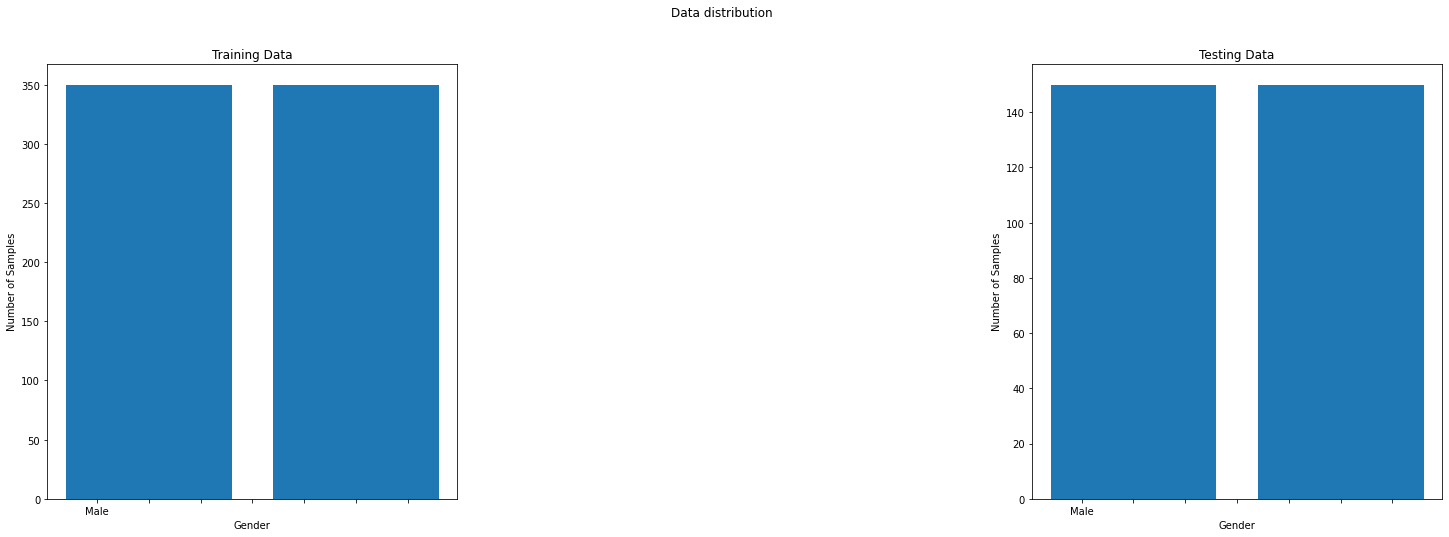

In [13]:
# Data distribution of samples per speaker
fig = plt.figure(figsize=[25, 8])
fig.suptitle("Data distribution")
ax = fig.add_subplot(1,3,1)
gender, samples = np.unique(y_train, return_counts=True)
ax.set_xticklabels(["Female", "Male"])
ax.bar(gender, samples)
ax.set_xlabel("Gender")
ax.set_ylabel("Number of Samples")
ax.set_title("Training Data")


ax = fig.add_subplot(1,3,3)
gender, samples = np.unique(y_test, return_counts=True)
ax.set_xticklabels(["Female", "Male"])
ax.bar(gender, samples)
ax.set_xlabel("Gender")
ax.set_ylabel("Number of Samples")
ax.set_title("Testing Data")

In [55]:
#Read images into array
x_train_img = []
for x in range(700):
    img_train = Image.open(f'../data/MelSpecImg/train/{x}.jpg') #load image
    img_train = img_train.resize((128,128)) #rescale
    x_train_img.append(np.asarray(img_train))
    
x_train_img = np.asarray(x_train_img)

In [73]:
#Read images into array
x_test_img = []
for x in range(300):
    img_test = Image.open(f'../data/MelSpecImg/test/{x}.jpg') #load image
    img_test = img_test.resize((128,128)) #rescale
    x_test_img.append(np.asarray(img_test))
    
x_test_img = np.asarray(x_test_img)

In [74]:
#convert remove 3 colour dimensions to 1
x_train_gray = convert_to_grayscale(x_train_img)
x_test_gray = convert_to_grayscale(x_test_img)

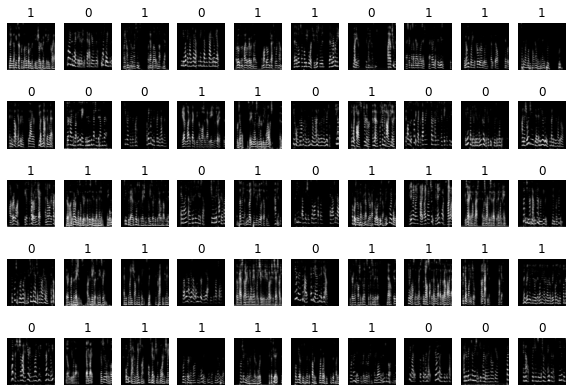

In [66]:
plot_images(x_train_gray[:,:,:,0],y_train)

In [30]:
print(f'x train: {len(x_train_gray)}')
print(f'y train: {len(y_train)}')
print(f'x test: {len(x_test_gray)}')
print(f'y test: {len(y_test)}')

x train: 700
y train: 700
x test: 300
y test: 300


# Modelling

Use Resnet_v2 for the project

Create a Dense layer 1 with activation sigmoid for the Binary Classification model

In [97]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x



def resnet_v2(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0],
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage, filters in enumerate(filters):
        num_filters_in = filters
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    return y

In [98]:
inputs = Input(shape=(128, 128, 1, ), name='img')
x = resnet_v2(inputs, [16, 32, 64], 1, 2)
output = Dense(1, activation='sigmoid')(x)
model_resnet_v2 = keras.Model(inputs=inputs, outputs=output, name='simple_resnet_v2')

In [99]:
model_resnet_v2.summary()

Model: "simple_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_35 (BatchN  (None, 128, 128, 16  64         ['conv2d_45[0][0]']              
 ormalization)                  )                                                  

## Train Model

Combine data and model to train the model

In [100]:
model_resnet_v2.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

history_start = process_time()

history = model_resnet_v2.fit(x_train_gray, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_data=(x_test_gray,y_test))

history_end = process_time()
print(f"{round(history_end - history_start,2)} seconds")

Epoch 1/10
11/11 [==============================] - 30s 3s/step - loss: 0.9925 - accuracy: 0.6600 - val_loss: 4.5364 - val_accuracy: 0.6933
Epoch 2/10
11/11 [==============================] - 28s 3s/step - loss: 0.4633 - accuracy: 0.8714 - val_loss: 5.1101 - val_accuracy: 0.6133
Epoch 3/10
11/11 [==============================] - 27s 2s/step - loss: 0.3830 - accuracy: 0.9214 - val_loss: 1.9933 - val_accuracy: 0.7167
Epoch 4/10
11/11 [==============================] - 26s 2s/step - loss: 0.2808 - accuracy: 0.9500 - val_loss: 0.7071 - val_accuracy: 0.8367
Epoch 5/10
11/11 [==============================] - 26s 2s/step - loss: 0.2478 - accuracy: 0.9629 - val_loss: 0.6585 - val_accuracy: 0.8467
Epoch 6/10
11/11 [==============================] - 26s 2s/step - loss: 0.2273 - accuracy: 0.9743 - val_loss: 0.4242 - val_accuracy: 0.8867
Epoch 7/10
11/11 [==============================] - 29s 3s/step - loss: 0.1965 - accuracy: 0.9843 - val_loss: 0.3657 - val_accuracy: 0.9267
Epoch 8/10
11/11 [==

In [102]:
print(f"{round(history_end - history_start,2)} seconds")

1281.04 seconds


## Predict

Assess the plot below, the training accuracy is converging to 1 and the model can no longer learn from the data.

We must add more data or use other techniques to improve model learning.

In [95]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
def plot_training(history):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.set_title('Resnet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.set_title('Resnet Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    ax.legend()
    
def eval_dnn(model, X_train, Y_train, X_test, Y_test, threshold = 0.5):
    test_scores = model.evaluate(X_test, Y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])
    
    display_labels = ['Male', 'Female']
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    
    test_time_start = process_time()
    pred = model.predict(X_train, verbose=False) > 0.5
    test_time_end = process_time()
    print(f"{round(test_time_end-test_time_start,2)} seconds")
    
    conf = ConfusionMatrixDisplay.from_predictions(y_true = Y_train, y_pred = pred, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance (f1): ' + str(f1_score(Y_train, pred)));
    conf.ax_.set_xticklabels(display_labels)
    conf.ax_.set_yticklabels(display_labels)

    ax = fig.add_subplot(1, 2, 2)
    pred = model.predict(X_test, verbose=False) > 0.5    
    conf = ConfusionMatrixDisplay.from_predictions(y_true = Y_test, y_pred = pred, normalize='true', ax=ax)
    
    
    conf.ax_.set_title('Testing Set Performance (f1): ' + str(f1_score(Y_test,pred)));
    #print(classification_report(Y_test, pred))
    conf.ax_.set_xticklabels(display_labels)
    conf.ax_.set_yticklabels(display_labels)

10/10 - 3s - loss: 0.3082 - accuracy: 0.9300 - 3s/epoch - 263ms/step
Test loss: 0.3081586956977844
Test accuracy: 0.9300000071525574
24.95 seconds


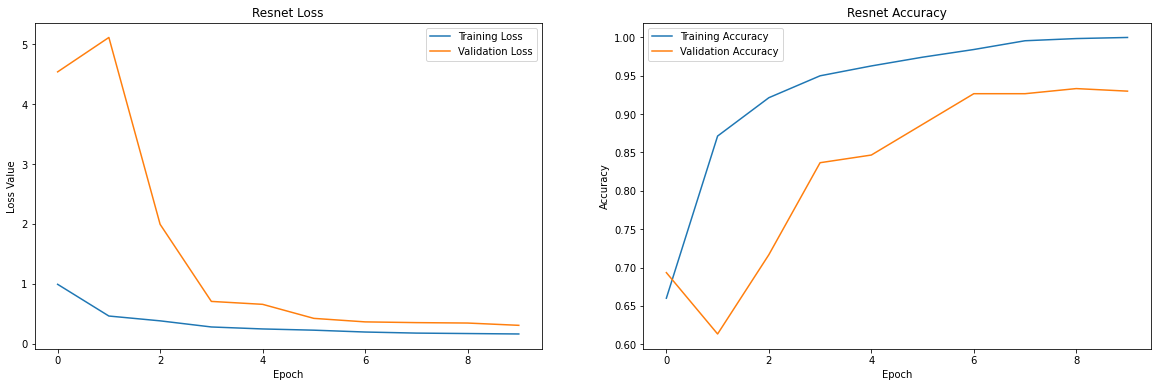

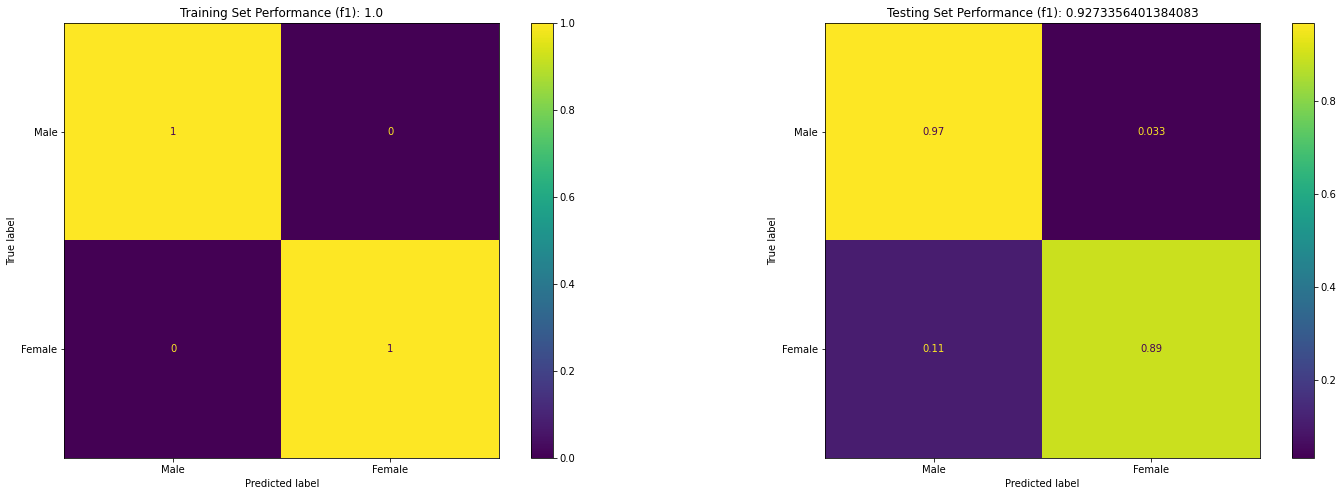

In [101]:
plot_training(history)
eval_dnn(model_resnet_v2, x_train_gray, y_train, x_test_gray, y_test)

## Finish